# TP n°2 : Support Vector Machine (SVM)

#### **Adrien Boitreaud**

In [125]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

#%matplotlib notebook
plt.style.use('ggplot')

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

#### **Answer**

We want to solve the problem 
$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}, \xi \in \mathbb{R}^n } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi_i \right) $$
under the constraints :$\xi_i \ge 0 $ and $ y_i(\langle\mathbf{w}, \phi(x_i)\rangle + w_0) \ge 1 - \xi_i$ \
Those constraints can be expressed as :
$$\forall i \in \{1, ...,n\},\xi_i \ge max(0,1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+w_0))$$
which is the same as $$\forall i \in \{1, ...,n\}, \xi_i \ge [1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+w_0)]_+$$


By writign the Lagrangian of the initial fuction under this constraint, we get: 
$$ L(\mathbf{w}, w, C) = \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$
So minimizing the initial function is equivalent to minimizing the Lagrangian written above.\
As there is no longer $\xi$ in the equation, the solution becomes:
$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

#### **Answer**
The classfication error for a classifier $g$ is $$ R(g) = \mathbb{E}[\sum _ {i=0}^n1(sign(g(x_i)) \neq y_i)]$$
But the indicator function is not convex and we want a convex function to minimize it easily. \
We thus take the hinge loss which is convex and also an upper bound of the inital loss function that uses the indicator function.

The new risk, which we will note $R_{hinge} $ is : 
$$ R_{hinge} = \mathbb{E}[\sum _ {i=0}^n{max}(0, 1-y_ig(x_i))]$$

## Example of using SVC (originally in ```svm_script.py```)

In [3]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

Score : 0.95


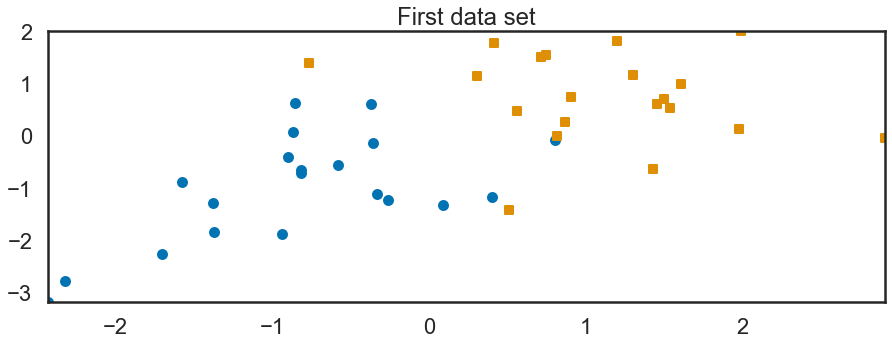

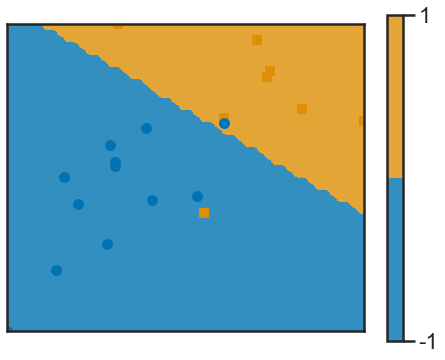

In [4]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

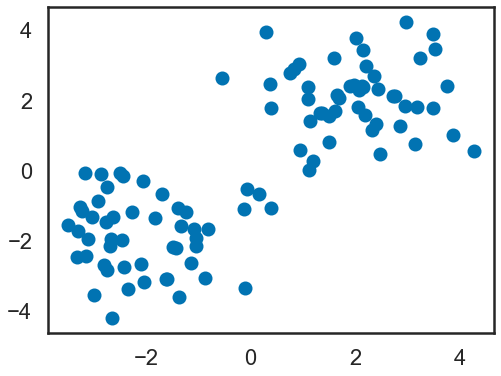

In [5]:
X, y = make_blobs(n_samples=100, cluster_std= 1, centers=[[2,2], [-2,-2]],
                  n_features=2,random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [7]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

def eta(sample):
    f = multivariate_normal.pdf(sample, mean=[2,2])
    g = multivariate_normal.pdf(sample, mean=[-2,-2])
    return f/(f+g)


def bayes_risk(X):
    l = [min(eta(sample), 1-eta(sample)) for sample in X]
    return np.mean(l)

In [8]:
print(f'The Bayes risk we have computed is {bayes_risk(X)}')

The Bayes risk we have computed is 0.00291086033606047


**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

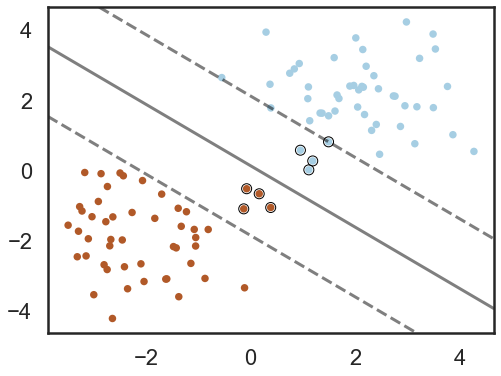

In [9]:
clf = svm.SVC(kernel="linear", C=0.1)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
           linestyles=["--", "-", "--"]
          )

# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()
#print the  numbers of support vectors
#print(clf.support_vectors_.shape[0])

For C = 1000, we only have 2 support vectors.\
For C = 0.1, we have 8 support vectors

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

In [10]:
def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.
    Parameters
    ----------
    X : data features
    y : label vector
    w :(optional) the separating hyperplan w
    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1],
                    c=np.reshape(color_blind_list[label_num], (1, -1)),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

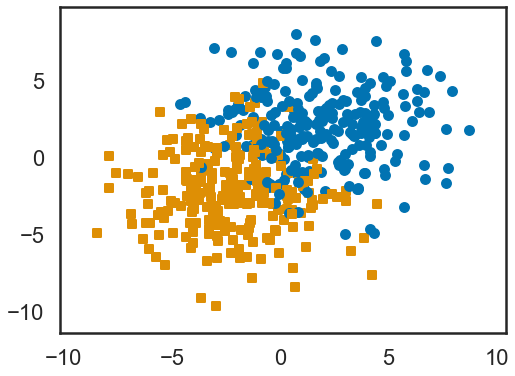

In [11]:
# Generate data and verify graphically that the two classes overlap
X, y = make_blobs(n_samples=500, cluster_std= 2.5, centers=[[2,2], [-2,-2]],
                  n_features=2,random_state=0)
plot_2d(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)

I used the plot_2d function from previous lab.\
We see that the classes are overlapping

In [12]:
# Find the best working C with a 5-fold cross-validation
svc = svm.SVC(kernel="linear")
C_grid = np.logspace(-4, 1, num=128)
param_grid = {'C': C_grid}
clf = GridSearchCV(svc, param_grid=param_grid, cv=5)
clf.fit(X_train, y_train)
print(f'The best C foud is {list(clf.best_params_.values())[0]}')

The best C foud is 0.0010558981944335786


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

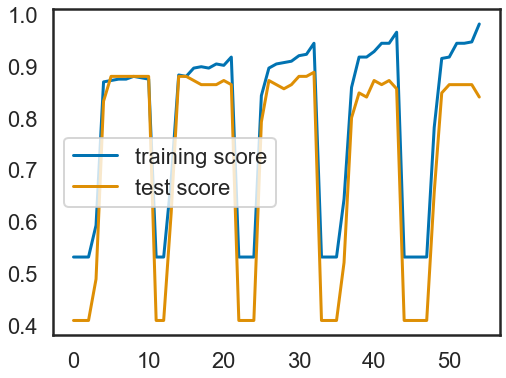

In [13]:
C_grid = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 3, 7, 10, 100]
gamma_grid = [1e-3, 1e-1, 0.5, 1, 1.5]
train_score=[]
test_score=[]

for gamma in gamma_grid:
    for C in C_grid:
        svc = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        svc.fit(X_train,y_train)
        train_score.append(svc.score(X_train,y_train))
        test_score.append(svc.score(X_test,y_test))
plt.plot(train_score, label='training score')
plt.plot(test_score, label='test score')
plt.legend()
plt.show()

This plot of the scores on the training dataset and on the test datasets shows that tuning SVM parameters can lead to overfitting. For a specific C and gamma, we see that, on the right side of the plot, the score is higher on the training dataset than on the test dataset. For the last three peaks (gamma = 0.5, 1 and 1.5), there is a gap between the two scores. This means that the model has learnt too precisely on the points of the training dataset and is not able to generalize well.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

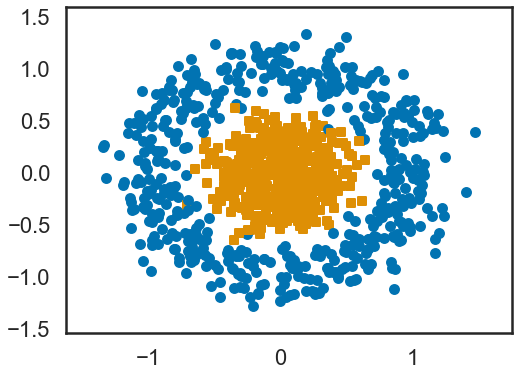

In [14]:
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.15, random_state=0)
plot_2d(X,y)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)

In [16]:
svc_gaussian = svm.SVC(kernel='rbf')
C_grid = np.logspace(-4, 3, num=8)
gamma_grid = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5]
param_grid = {'C': C_grid, 'gamma':gamma_grid}
clf_gauss = GridSearchCV(svc_gaussian, param_grid=param_grid, cv=5)
clf_gauss.fit(X_train, y_train)
print('Best parameters:', clf.best_params_)

Best parameters: {'C': 0.0010558981944335786}


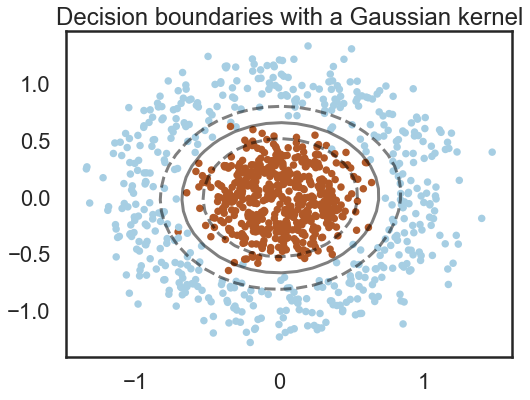

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_gauss.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
           linestyles=["--", "-", "--"]
          )
plt.title('Decision boundaries with a Gaussian kernel')
plt.show()

In [18]:
svc_poly = svm.SVC(kernel='poly')
C_grid = np.logspace(-4, 3, num=8)
gamma_grid = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5]
param_grid = {'C': C_grid, 'gamma':gamma_grid}
clf_poly = GridSearchCV(svc, param_grid=param_grid, cv=5)
clf_poly.fit(X_train, y_train)
print('Best parameters:', clf.best_params_)

Best parameters: {'C': 0.0010558981944335786}


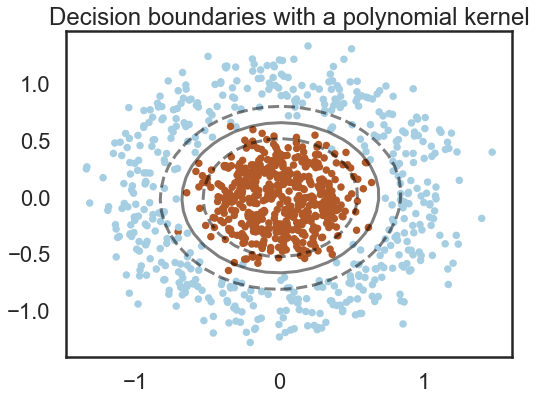

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_poly.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
           linestyles=["--", "-", "--"]
          )
plt.title('Decision boundaries with a polynomial kernel')
plt.show()

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

In order to choose the best kernel, we want to know which one performs best. Of course, we will run all algorithm on the same dataset. We must firstly know what the best parameters are for each kernel. This can be done thanks to cross-validation, as we did in question 6. Then, we can evaluate each kernel on compare their score on the test dataset. If two kernels are performing equally,  we can select the less complex kernel.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

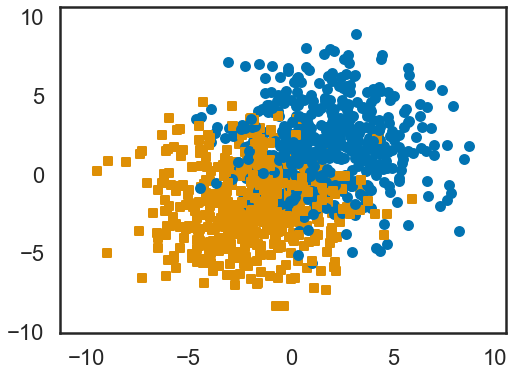

In [20]:
X, y = make_blobs(n_samples=1000, cluster_std= 2.5, centers=[[2,2], [-2,-2]],
                  n_features=2,random_state=0)
plot_2d(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)

In [21]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
def eta(sample, mean1, mean2):
    f = multivariate_normal.pdf(sample, mean=mean1)
    g = multivariate_normal.pdf(sample, mean=mean2)
    return f/(f+g)


def bayes_risk(X, mean1, mean2):
    l = [min(eta(sample, mean1, mean2), 1-eta(sample, mean1, mean2)) for sample in X]
    return np.mean(l)

In [22]:
C=0.001 # we take C close to what the cross validation has given in question 6
svc = svm.SVC(kernel='linear', C=C)
train_score, test_score, bayes = [], [], []
for k in np.linspace(3, 750, 25, dtype=int):
    idx = np.random.randint(0, 750, k)
    svc.fit(X_train[idx,:] ,y_train[idx])
    train_score.append(svc.score(X_train[idx,:] ,y_train[idx]))
    test_score.append(svc.score(X_test,y_test))
    bayes.append(1 - bayes_risk(X_train[idx,:], [2,2], [-2,-2]))

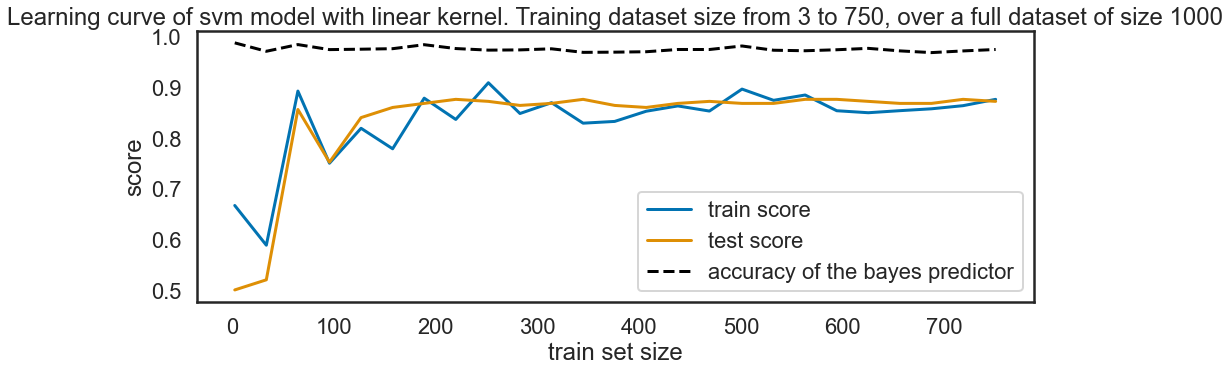

In [23]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(3, 750, 25, dtype=int), train_score, label='train score')
plt.plot(np.linspace(3, 750, 25, dtype=int), test_score, label='test score')
plt.plot(np.linspace(3, 750, 25, dtype=int), bayes, label='accuracy of the bayes predictor', linestyle='--', color='black')
plt.xlabel('train set size')
plt.ylabel('score')
plt.legend()
plt.title('Learning curve of svm model with linear kernel. Training dataset size from 3 to 750, over a full dataset of size 1000')
plt.show()

We see that the learning curve quickly plateaus close to 0.9 for a training dataset as small as 100 samples. It never reaches the theoretical accuracy of the bayes predictor.

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


In [251]:
# Modify the class of some data points randomly
idx = np.random.randint(0, 750, 75) # 10% of the training dataset will be changed
y_train_noise = y_train.copy()
y_train_noise[idx] = 1 - y_train[idx]

In [263]:
C_grid = np.logspace(-5, 3, 64)
train_score=[]
test_score=[]

for C in C_grid:
    svc = svm.SVC(kernel='linear', C=C, gamma=gamma)
    svc.fit(X_train,y_train_noise)
    train_score.append(1-svc.score(X_train,y_train_noise))
    test_score.append(1-svc.score(X_test,y_test))

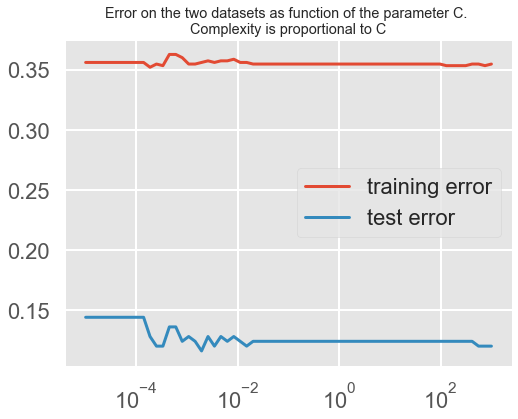

In [265]:
plt.plot(C_grid, train_score, label='training error')
plt.plot(C_grid, test_score, label='test error')
plt.legend()
plt.title('Error on the two datasets as function of the parameter C. \nComplexity is proportional to C')
plt.xscale("log")
plt.show()

As C grows, making the model more complex, we see that the test error is getting slightly smaller. We also see that the training error is greater than the test error, which makes sense since we added some noise.

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regularization parameter C.

In [267]:
%run svm_gui.py

fit the model
Accuracy: 78.26086956521739
fit the model
Accuracy: 95.65217391304348
fit the model
Accuracy: 95.74468085106383
fit the model
Accuracy: 95.83333333333334
fit the model
Accuracy: 95.91836734693877
fit the model
Accuracy: 96.0
fit the model
Accuracy: 96.07843137254902
fit the model
Accuracy: 96.15384615384616
fit the model
Accuracy: 96.22641509433963
fit the model
Accuracy: 96.29629629629629
fit the model
Accuracy: 96.36363636363636
fit the model
Accuracy: 96.42857142857143
fit the model
Accuracy: 94.73684210526315
fit the model
Accuracy: 94.82758620689656
fit the model
Accuracy: 94.91525423728814
fit the model
Accuracy: 95.0
fit the model
Accuracy: 95.08196721311475
fit the model
Accuracy: 95.16129032258065
fit the model
Accuracy: 95.23809523809523
fit the model
Accuracy: 95.3125
fit the model
Accuracy: 95.38461538461539
fit the model
Accuracy: 95.45454545454545
fit the model
Accuracy: 95.52238805970148
fit the model
Accuracy: 97.01492537313433
fit the model
Accuracy: 97.0

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

In [268]:
%run svm_gui.py

fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 100.0
fit the model
Accuracy: 89.0625
fit the model
Accuracy: 89.23076923076924
fit the model
Accuracy: 89.39393939393939
fit the model
Accuracy: 89.55223880597015
fit the model
Accuracy: 97.01492537313433
fit the model
Accuracy: 98.50746268656717
fit the model
Accuracy: 89.55223880597015
fit the model
Accuracy: 97.01492537313433
fit the model
Accuracy: 89.55223880597015
fit the model
Accuracy: 97.01492537313433
fit the model
Accuracy: 98.50746268656717


**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

With a simple model given by the choice of C=1e-3, the margins are very large and the classification error is great.
Indeed, the separation between the two classes is not in the right place and lets all the points on the same side.
This is mainly due to the fact that the classes are not balanced and the black class only accounts for 10% of the total points


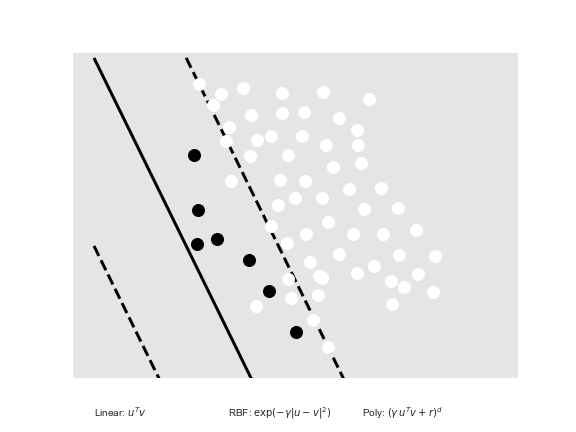

In [2]:
from IPython.display import Image
print('With a simple model given by the choice of C=1e-3, the margins are very large and the classification error is great.\nIndeed, \
the separation between the two classes is not in the right place and lets all the points on the same side.\
\nThis is mainly due to the fact that the classes are not balanced and the black class only accounts for 10% of the total points')
Image('C=10-3.png')

With C=1e-2, the model is already much better but still misclassifies one point that could have been well-classified.
The margings are also looking much smaller than in the previous case with C=1e-3.


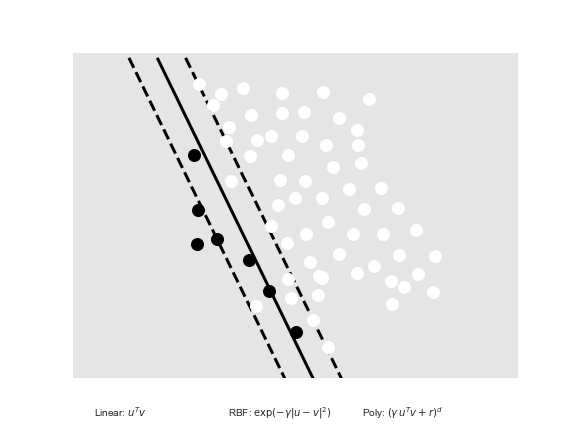

In [280]:
print('With C=1e-2, the model is already much better but still misclassifies one point that could have been well-classified.\
\nThe margings are also looking much smaller than in the previous case with C=1e-3.')
Image('C=10-2.png')

For a much more complex model, with C=10, all the points that can be separated are well classified and the margins again look much smaller.


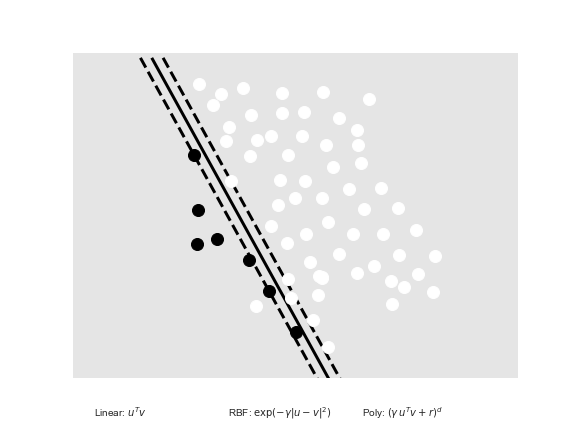

In [285]:
print('For a much more complex model, with C=10, all the points that can be separated \
are well classified and the margins again look much smaller.')
Image('c=10.png')

## Going further : application to face classification

Code for downloading and organizing the data:

In [87]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

In [88]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()
C_grid = np.logspace(-5, 5, 16)
error, chance, acc = [], [], []
for C in C_grid:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    error.append(1 - score)
    #######
    #print("Predicting the people names on the testing set")
    t0 = time()

    # predict labels for the X_test images
    y_pred = clf.predict(X_test)

    #print("done in %0.3fs" % (time() - t0), 'for C = ', C)
    #print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
    #print("Accuracy : %s" % clf.score(X_test, y_test))
    chance.append(max(np.mean(y), 1. - np.mean(y)))
    acc.append(clf.score(X_test, y_test))


Fitting the classifier to the training set


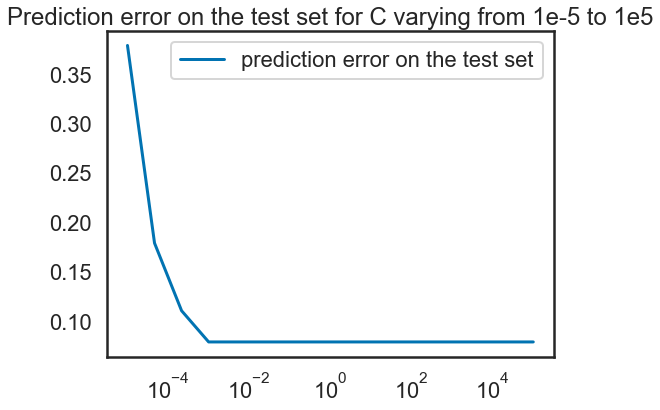

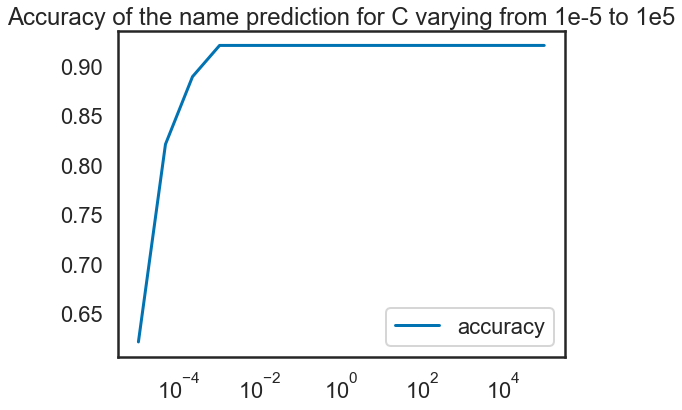

In [112]:
plt.plot(C_grid, error, label='prediction error on the test set')
plt.legend()
plt.title('Prediction error on the test set for C varying from 1e-5 to 1e5')
plt.xscale("log")
plt.show()

plt.plot(C_grid, acc, label='accuracy')
plt.legend()
plt.title('Accuracy of the name prediction for C varying from 1e-5 to 1e5')
plt.xscale("log")
plt.show()

In [90]:
###Code used to plot the chance level and the accuracy of predicting the names
#If ran here, we used C = 100 000.
print("Predicting the people names on the testing set with C =1e5")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set with C =1e5
done in 0.176s
Chance level : 0.6210526315789474
Accuracy : 0.9210526315789473


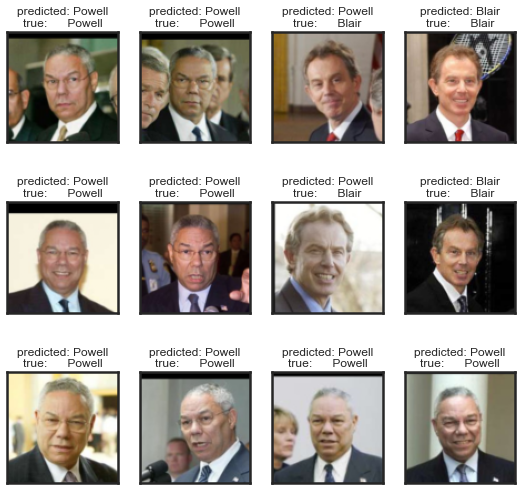

In [91]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

In [108]:
noise_variables = np.linspace(1, 20000, 32, dtype = int) #up to 10000 variables added, 1/3 of correct variables in the final set
clf = svm.SVC(kernel="linear", C=0.1)
score = []

for number in noise_variables:
    # Add variables to make noise
    new_var = np.random.normal(size = (X[:,0].shape[0], number))
    X_noise = np.hstack((X, new_var))
    
    #split in train and test set
    indices = np.random.permutation(X_noise.shape[0])
    train_idx, test_idx = indices[:int(X_noise.shape[0] / 2)], indices[int(X_noise.shape[0] / 2):]
    X_train, X_test = X_noise[train_idx, :], X_noise[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #fit the classifier and predict
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))

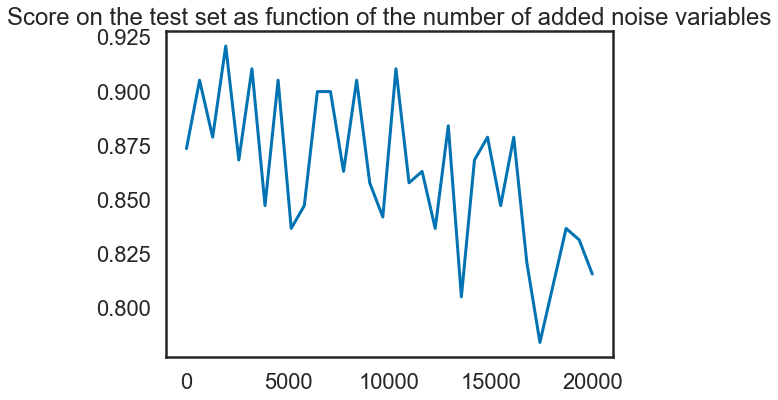

In [111]:
plt.plot(noise_variables, score)
plt.title('Score on the test set as function of the number of added noise variables')
plt.show()

**18)** Explain why the features are centered and reduced.

The features are centered and reduced to make the computations of the separating hyperplane simpler and faster.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

In [119]:
kernels = {'linear', 'poly', 'rbf', 'sigmoid'}

In [121]:
# Come back to unnoisy dataset
indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    print(f'For {kernel} kernel, the score on test set is {clf.score(X_test, y_test)}')

For linear kernel, the score on test set is 0.9105263157894737
For sigmoid kernel, the score on test set is 0.8263157894736842
For rbf kernel, the score on test set is 0.8
For poly kernel, the score on test set is 0.6578947368421053


We see that the linear kernel is the one that performs best on this dataset.

In [184]:
n_components = 15
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
X_pca = pca.fit_transform(X)
print(f'We have kept {(sum(pca.explained_variance_ratio_)*100):.1f}% of the variance with {n_components} components')
indices = np.random.permutation(X_pca.shape[0])
train_idx, test_idx = indices[:int(X_pca.shape[0] / 2)], indices[int(X_pca.shape[0] / 2):]
X_train, X_test = X_pca[train_idx, :], X_pca[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

We have kept 65.8% of the variance with 15 components


In [185]:
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    print(f'For {kernel} kernel, the score on test set is {clf.score(X_test, y_test)}')

For linear kernel, the score on test set is 0.8105263157894737
For sigmoid kernel, the score on test set is 0.7736842105263158
For rbf kernel, the score on test set is 0.8
For poly kernel, the score on test set is 0.7789473684210526


Applying a PCA and keeping only 15 variables out of the inital 10,000, which reprensented 65% of the variance, we were able to significantly improve the score of the polynomial kernel for example. The accuracy went from 0.65 to 0.78, which reprensents an improvement of 20%.

However, no kernel performs as well as the linear kernel trained on the dataset with all the variables, whatever number of variables we keep with the PCA.